# метрики классификации

1. [first prepare](#first-prepare)
2. [скор и пороги](#скор-и-пороги)
3. [матрица ошибок](#матрица-ошибок)
4. [Recall полнота](#Recall-полнота)
5. [Precision точность](#Precision-точность)
6. [F metric](#F-metric)
7. [Accuracy metric](#Accuracy-metric)
8. [classification report](#classification-report)
9. [ROC metric](#ROC-metric)
10. [ROC AUC](#AUC-насколько-модель-хороша-в-плане-ROC)
11. [precision recall curve](#precision-recall-curve)
12. [human and machine learning compare](#human-and-machine-learning-compare)

# first prepare
    импорты, чтение данных и создание выборок

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split



In [5]:
df = pd.read_csv('Churn_Modelling.csv')
train, test = train_test_split(df,train_size=0.6,random_state=42,stratify=df['Exited'])
val, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['Exited'])


# человеческое обучение 
    человеческое обучение по двум переменным NumOfProducts и age_group

In [6]:
# Разбиение на группы по возрасту:
train['age_group'] = pd.cut(train['Age'], [0, 31, 35, 40, 46, float('inf')])

In [7]:
# Группировка по продуктам и возрасту  и создание модели
model = train.groupby(['NumOfProducts', 'age_group'])['Exited'].mean().reset_index()

/tmp/ipykernel_29765/2995531130.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = train.groupby(['NumOfProducts', 'age_group'])['Exited'].mean().reset_index()


In [8]:
model = model.rename({"Exited": "score_prod_age"}, axis=1)


In [9]:
# Объединение с тренировочными и тестовыми данными:
train = train.merge(model,how='left',on=['NumOfProducts','age_group'])


In [10]:
test['age_group'] = pd.cut(test['Age'],[0,31,35,40,46,float('inf')])


In [11]:
test = test.merge(model,how='left',on=['NumOfProducts','age_group'])


# Машинное обучение
    создал набор признаков X, которые будут использоваться для обучения модели
    определил целевую переменную y, которую нужно предсказать.
    Переменные cat_features указаны как категориальные признаки, что важно для моделей, таких как CatBoost, так как она умеет обрабатывать категориальные данные напрямую
    
    Создание пулов данных (Pool) для CatBoost:
    Модели CatBoost работают с объектами типа Pool, которые хранят данные, метки и информацию о категориальных признаках. Я создал такие пулы для тренировочных данных и данных для валидации (валидирующего набора).
    
    Задание параметров модели:
    Я определил параметры для модели, такие как learning_rate (скорость обучения), случайное зерно для воспроизводимости (random_seed) и количество выводимых сообщений (verbose).
    
    Обучение модели:

    Модель обучается на тренировочных данных и использует валидационные данные для оценки её качества во время обучения.
    В процессе я вижу, как постепенно уменьшается ошибка на тестовых данных (в моем случае это log loss), и на какой итерации достигается лучший результат.
    
    Оценка качества и использование модели для предсказаний:
    После обучения я использую модель для предсказания на тестовых данных, получая вероятности с помощью метода predict_proba.



In [12]:
# ! pip install catboost


In [13]:
from catboost import CatBoostClassifier


In [14]:
X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

cat_features = ['Geography','Gender']

y = ['Exited']

In [15]:

from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [16]:

params = {'verbose':100,
          'random_seed':42,
          'learning_rate':0.01}

In [17]:
model = CatBoostClassifier(**params)


In [18]:
model.fit(train_data,eval_set=valid_data)


0:	learn: 0.6848575	test: 0.6849145	best: 0.6849145 (0)	total: 51.9ms	remaining: 51.8s
100:	learn: 0.3908412	test: 0.3894043	best: 0.3894043 (100)	total: 365ms	remaining: 3.24s
200:	learn: 0.3457312	test: 0.3445503	best: 0.3445503 (200)	total: 663ms	remaining: 2.64s
300:	learn: 0.3288071	test: 0.3307084	best: 0.3307084 (300)	total: 961ms	remaining: 2.23s
400:	learn: 0.3192987	test: 0.3252459	best: 0.3252459 (400)	total: 1.27s	remaining: 1.89s
500:	learn: 0.3120470	test: 0.3221057	best: 0.3221057 (500)	total: 1.58s	remaining: 1.57s
600:	learn: 0.3054735	test: 0.3204300	best: 0.3204300 (600)	total: 1.9s	remaining: 1.26s
700:	learn: 0.2997053	test: 0.3192377	best: 0.3192377 (700)	total: 2.2s	remaining: 939ms
800:	learn: 0.2946934	test: 0.3188206	best: 0.3187917 (794)	total: 2.55s	remaining: 635ms
900:	learn: 0.2890177	test: 0.3185731	best: 0.3185731 (900)	total: 2.81s	remaining: 309ms
999:	learn: 0.2831978	test: 0.3186396	best: 0.3185004 (978)	total: 3.05s	remaining: 0us

bestTest = 0.318

In [19]:
test['score_catboost'] = model.predict_proba(test[X])[:,1]


# скор и пороги
    есть два скор: 
        - один у человеческого обучения score_prod_age(построен на количестве продукта и возрасте)
        - другой на основе машинного обучения (построен на всех фичах)
    
    скор - это то что выходит из модели классификации. Это оценка, которая показывает склонность в данном случае человека к оттоку. Чем больше скор, тем больше человек склонен к оттоку и наооборот
    Эта задача классификации. есть таргет Exited может быть 0 или 1. скор всегда от 0 до 1

In [20]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715


    как на основе скора получить класс, как принять решение - отточный клиент или не отточный
    нужен какой нибудь порог. допустим 0.5(если боольше 0.5 значит отток, если меньше то не отток)
    

<Axes: >

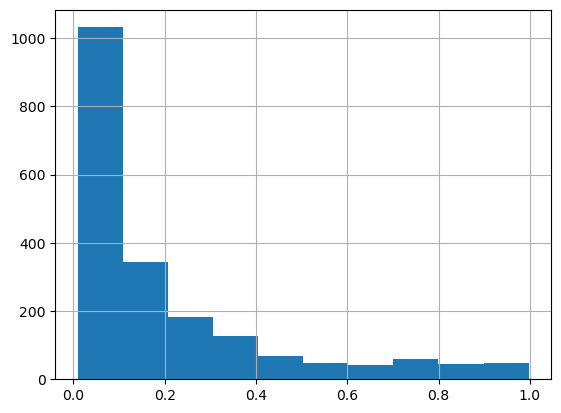

In [21]:
# видно в таблице что если порог будет 0.5, то это в принципе то что и наддо. так как в данных только 20 процентов 
# отток клиентов
test['score_catboost'].hist() 

In [22]:
train['Exited'].mean()

0.20366666666666666

In [23]:
# как получить решение(отток или не отток)
# y_true - в нашем случае Exited
test['y_pred'] = test['score_catboost'] > 0.5 # типа наше предсказание.

In [24]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,False
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,False
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,False
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,False
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,False
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,False
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,False
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,False


In [25]:
# но удобней иметь не False jr  True в игрек предсказанное, а 0 или 1, так же как и у таргета
test['y_pred'] = (test['score_catboost'] > 0.5) * 1
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0


In [26]:
test['y_pred'].mean() # 12 процентов, кому мы предсказалил отток

0.1225

# матрица ошибок
    учимся анализировтаь ответ 
    надо сравнивать наш таргет(целевой признак) и y_pred

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_true=test['Exited'],y_pred=test['y_pred'])

array([[1537,   56],
       [ 218,  189]])

In [29]:
tn, fp, fn, tp = confusion_matrix(y_true=test['Exited'],y_pred=test['y_pred']).ravel()

In [30]:
tn, fp, fn, tp

(1537, 56, 218, 189)

    
    что видно.
    True and negative or positive
    True - значит ответы совпали (negative это 0, positive это 1 у y_pred)
    tn = true negative(когда и таргет и y_pred) показали 0 = 1537
    fp = true positive(когда и таргет и y_pred) показали 1 = 189
    
    False and negative or positive
    False значит ответы не совпали (negative это 0, positive это 1 у y_pred)
    fp = false positive y_pred показал 1 = 56
    tn = false negative y_pred показал 0 = 218
    
    в основном ошибки в FN - это когда клиент был отточным, но модель его пропустила(модель не доглядела)
    и FP - это когда оттока не было, но модель сказала что был отток

# Recall полнота
    первая метрика так же называетсся sensetivity, hit rate, true positive rate
    
    это процент еденичек, которая модель правильно прометила как еденички. 
    насколько хорошо в случае нашей задачи, модель подсвечивает отточного клиента
    
    для рекола используется FN TP

In [31]:
recall = tp / (tp + fn)

In [32]:
recall # получилось 46 процентов

0.4643734643734644

In [33]:
from sklearn.metrics import recall_score

recall_score(test['Exited'], test['y_pred'])

0.4643734643734644

# Precision точность
    или positive predicted value, но лучше называть precision
    показывает процент правильных едениц, среди всех предсказанных едениц
    
    Precision использует 
    FP TP

In [34]:
precision = tp / (tp + fp)

In [35]:
precision

0.7714285714285715

In [36]:
from sklearn.metrics import precision_score

precision_score(test['Exited'], test['y_pred'])

0.7714285714285715

# F metric
    комбинация между precision and recall. как бы объединяет их
    гармоническое среднее

In [37]:
f1 = (2 * recall * precision) / (recall + precision)
f1 

0.5797546012269938

In [38]:
from sklearn.metrics import f1_score


In [39]:
f1_score(test['Exited'], test['y_pred']) # вот правльный ответ

0.5797546012269938

# Accuracy metric
    процент правильных ответов
    в скольких процентах случаев, модель правльно предсказала класс.
    посчитать это можно даже без матрицы ошибок
    
    В задачах с несбалансированными классами (где один класс встречается значительно чаще, чем другой) accuracy может вводить в заблуждение, потому что она не учитывает пропорции между классами.
    
    Пример:
    Допустим, у тебя есть задача бинарной классификации, где:

    95% данных принадлежат к классу 0 (например, клиенты, которые не ушли),
    5% данных принадлежат к классу 1 (например, клиенты, которые ушли).
    Теперь представим, что модель просто всегда предсказывает, что клиент не уйдет (класс 0). Модель будет предсказывать правильно для 95% случаев, и точность (accuracy) будет 95%.
    
    
    для не сбалансированных лучше Precision, Recall и F1-Score:

In [40]:
(test['Exited'] == test['y_pred']).mean() # без матрицы

0.863

In [41]:
(tp + tn) / (tp + tn + fp + fn) # с помощью матрицы

0.863

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(test['Exited'], test['y_pred'])

0.863

# classification report
    отчет о классификации, для всех этих метрик
    
    
    это были основыне метрики. Но проблема их, что они посчитаны для одного порога. для порога 0.5
    то что я написал выше
    test['y_pred'] = (test['score_catboost'] > 0.5) * 1
    
    но порогов может быть больше. что если порог измениться и получатся метрики лучше

In [43]:
from sklearn.metrics import classification_report

In [44]:
classification_report(test['Exited'], test['y_pred']) # использовать принт для нее

'              precision    recall  f1-score   support\n\n           0       0.88      0.96      0.92      1593\n           1       0.77      0.46      0.58       407\n\n    accuracy                           0.86      2000\n   macro avg       0.82      0.71      0.75      2000\nweighted avg       0.85      0.86      0.85      2000\n'

In [45]:
print(classification_report(test['Exited'], test['y_pred']))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [46]:
test['y_pred_new'] = (test['score_catboost'] > 0.4) * 1

In [47]:
print(classification_report(test['Exited'], test['y_pred_new']))  

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.70      0.54      0.61       407

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



    подсчет Ф1 для всех порогов, и найду порог для максимальной Ф1

In [48]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_new
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0,0


In [49]:
test['score_catboost'].nunique() # все уникальные

2000

In [50]:
thrs = list(test['score_catboost'].unique()) # сохраняю пороги

In [51]:
thrs[:20]

[0.13184386080460458,
 0.07401954387476314,
 0.18687567474270395,
 0.0874034938715728,
 0.056658162909274605,
 0.06161072773132977,
 0.5563161171624521,
 0.20388734500811342,
 0.0455555402676573,
 0.3665912024509706,
 0.05285404501123437,
 0.023898613831695264,
 0.025687510422433404,
 0.1636902819818866,
 0.253926767059399,
 0.7564224487666255,
 0.01869061442130417,
 0.5052261796760974,
 0.07183857505482731,
 0.035709043055949935]

    и туда нужно положить еще один порог. нужно положить тот порог, при котором все объекты получат метку 1

In [52]:
min(thrs) # минимальный отличается от нуля. так что подложу еще 0 туда

0.009371218568204347

In [53]:
thrs = [0] + list(test['score_catboost'].unique())

In [54]:
len(thrs)

2001

    теперь есть все необходимые пороги,при котороых я могу посчитать Ф1
    
    
    thr — это порог, который определяет, с какого значения вероятности (или score_catboost) модель будет относить наблюдение к классу 1 (положительный класс). В бинарной классификации стандартный порог — 0.5, то есть если вероятность больше 0.5, объект предсказывается как класс 1, иначе как класс 0.

    thrs — это набор порогов. Например, это может быть список значений [0.1, 0.2, 0.3, ..., 0.9]. То есть в этом цикле код проверяет, как изменятся предсказания модели при разных значениях порога.

    test['score_catboost'] — это вероятности, которые модель CatBoost предсказала для каждого наблюдения. Эти значения находятся в диапазоне от 0 до 1 и показывают вероятность принадлежности к классу 1.

    test['y_pred_new'] = (test['score_catboost'] > thr) * 1:

    Здесь для каждого порога thr создаются новые предсказания (y_pred_new) на основе вероятностей score_catboost.
    (test['score_catboost'] > thr) возвращает True для тех наблюдений, где вероятность выше порога thr, и False — где ниже.
    Умножение на 1 (то есть * 1) преобразует True в 1 (класс 1), а False в 0 (класс 0).
    Таким образом, для каждого порога thr ты создаёшь новую колонку y_pred_new, в которой записывается предсказанный класс 1 или 0, в зависимости от того, больше ли вероятность score_catboost порога thr.

In [55]:
# для каждого порога, буду делать предикт
# Этот код позволяет исследовать, как изменяются предсказания модели при разных порогах

from tqdm.notebook import tqdm
result = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_catboost'] > thr) * 1
    result.append((thr, # что бы видеть еще и порог помимо Ф1
                   f1_score(test['Exited'], test['y_pred_new'])))

  0%|          | 0/2001 [00:00<?, ?it/s]

In [56]:
t = pd.DataFrame(result, columns=['thr', 'f1'])

In [57]:
t.sort_values('f1', ascending=False)

,thr,f1
640,0.277932,0.636771
623,0.280837,0.636569
1343,0.276637,0.636058
1756,0.331582,0.636025
1228,0.278005,0.635955
...,...,...
238,0.992916,0.019465
315,0.993195,0.014634
180,0.994941,0.009780
1205,0.997245,0.004902


In [58]:
t['f1'].max()

0.6367713004484306

In [59]:
t[t['f1'] == t['f1'].max()]

,thr,f1
640,0.277932,0.636771


# теперь тоже самое сделаю для ручной модели

In [60]:

from tqdm.notebook import tqdm

thrs = [0] + list(test['score_prod_age'].unique())


result = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_prod_age'] > thr) * 1
    result.append((thr, # что бы видеть еще и порог помимо Ф1
                   f1_score(test['Exited'], test['y_pred_new'])))





  0%|          | 0/17 [00:00<?, ?it/s]

In [61]:
t = pd.DataFrame(result, columns=['thr', 'f1'])

In [62]:

t[t['f1'] == t['f1'].max()]

,thr,f1
8,0.236364,0.559441


    видно что ручная модель проигрывает кетбусту по ф1 метрике
    ну и теперь можно попробоавть предсказания с другим порогом или еще что

# ROC metric
    иногда и порог не нужен. достаточно просто скор, что бы узнать их склонность к оттоку или покупке или еще что то. не всегда нужно принимать конечное решение и преобразовывать скор в класс.
    иногда полезней оценивать не конкретный порог а скор в целом. и для этого ROC
    Reciver operating characteristic

In [63]:
from sklearn.metrics import roc_curve

In [64]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_new
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0,0


In [65]:
# false positive rate, true positive rate и пороги
fprs, tprs, thrs = roc_curve(test['Exited'], test['score_catboost'])

In [66]:
roc = pd.DataFrame({'fpr': fprs, 'tpr': tprs, 'thr': thrs})
roc # теперь я вижу порог и соответсвующий ему true positive folse positive rate

,fpr,tpr,thr
0,0.000000,0.000000,1.997318
1,0.000000,0.002457,0.997318
2,0.000000,0.061425,0.933737
3,0.000628,0.061425,0.933203
4,0.000628,0.120393,0.891551
...,...,...,...
391,0.979912,0.995086,0.012212
392,0.979912,0.997543,0.012198
393,0.998745,0.997543,0.009886
394,0.998745,1.000000,0.009809


<Axes: xlabel='fpr'>

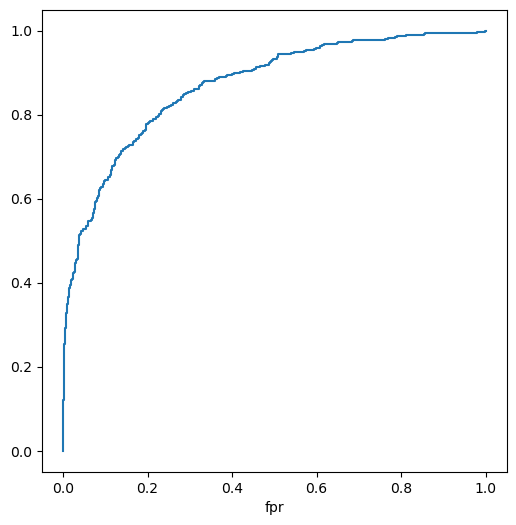

In [67]:
# если хочу что бы что то было по ИКСУ то ставлю set_index
roc.set_index('fpr')['tpr'].plot(figsize=(6,6))

In [68]:
roc['random'] = roc['fpr'] # икс равен игреку

In [69]:
roc['ideal'] = 1 # для идеальной модели. tpr всегда равен 1

<Axes: xlabel='fpr'>

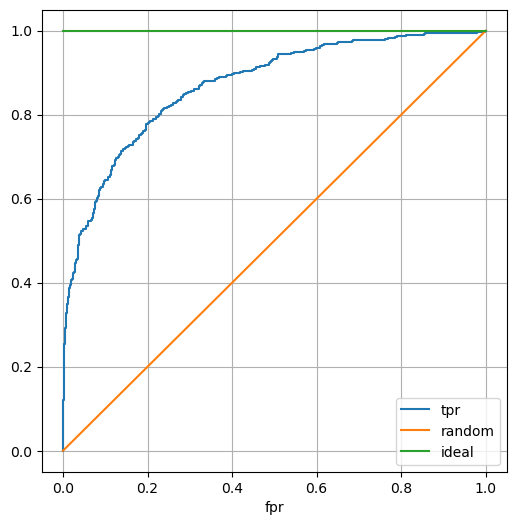

In [70]:
roc.plot(x='fpr', y=['tpr', 'random', 'ideal'], figsize=(6,6), grid=True)

    часто для построения ROC кривой, просто копи паст из старых  проектов
    или из интернета. загуглить
    https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    

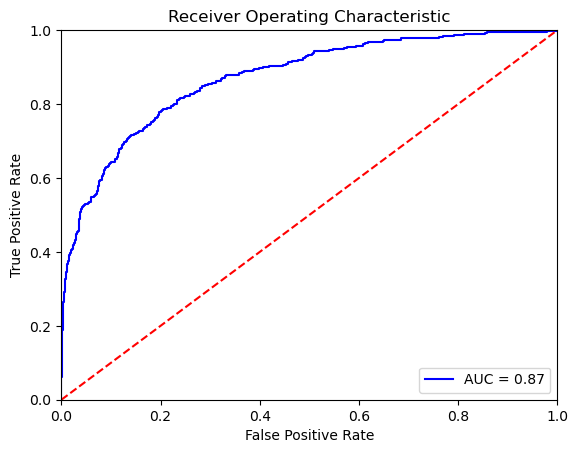

In [71]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test['Exited'], test['score_catboost'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

    auc - area under curve. площадь под кривой

In [72]:
from catboost.utils import get_roc_curve

In [73]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features)

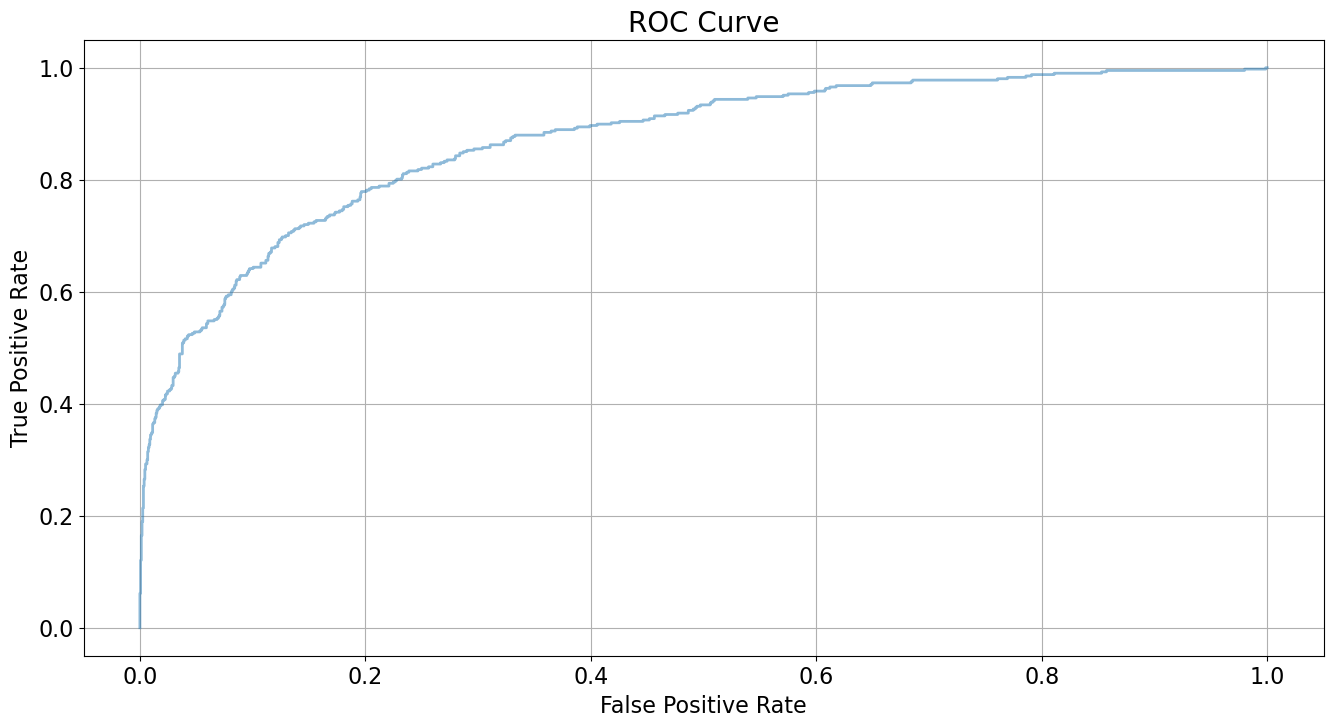

In [74]:
# точка с запятой,  что бы массивы не выводились после графика
get_roc_curve(model, test_data, plot=True);

# AUC насколько модель хороша в плане ROC
    roc auc это площадь под кривой
    можно при обучении модели сразу на валидации смотрет на roc auc

    ROC AUC правктически всегда используется, и она наверное самая популярная

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
roc_auc_score(test['Exited'], test['score_catboost'])

0.8703063618317854

In [77]:


params = {'verbose':100,
          'eval_metric': 'AUC', # log loss был по умолчанию, а теперь сразу AUC
          'random_seed':42,
          'learning_rate':0.01}

model = CatBoostClassifier(**params)


model.fit(train_data,eval_set=valid_data)


0:	test: 0.8338545	best: 0.8338545 (0)	total: 2.51ms	remaining: 2.5s
100:	test: 0.8725090	best: 0.8725090 (100)	total: 254ms	remaining: 2.26s
200:	test: 0.8784656	best: 0.8784656 (200)	total: 525ms	remaining: 2.08s
300:	test: 0.8812676	best: 0.8812676 (300)	total: 800ms	remaining: 1.86s
400:	test: 0.8823868	best: 0.8824376 (390)	total: 1.08s	remaining: 1.61s
500:	test: 0.8834491	best: 0.8834522 (498)	total: 1.35s	remaining: 1.34s
600:	test: 0.8834737	best: 0.8836554 (564)	total: 1.6s	remaining: 1.06s
700:	test: 0.8837847	best: 0.8838694 (685)	total: 1.85s	remaining: 789ms
800:	test: 0.8834383	best: 0.8838694 (685)	total: 2.1s	remaining: 522ms
900:	test: 0.8829318	best: 0.8838694 (685)	total: 2.44s	remaining: 268ms
999:	test: 0.8822744	best: 0.8838694 (685)	total: 2.7s	remaining: 0us

bestTest = 0.8838694083
bestIteration = 685

Shrink model to first 686 iterations.


# ROC AUC при сильно несбалансированных классах
    

In [78]:
# сильно несбалансированный датафрейм для теста
t = pd.DataFrame({'y_true': [0] * 990 + [1] * 10})

In [79]:
t.value_counts()

y_true
0         990
1          10
Name: count, dtype: int64

In [80]:
t['y_true'].mean() # 1% едениц

0.01

In [81]:
import numpy as np

In [82]:
# добавлю шума
np.random.uniform(0, 0.2), np.random.uniform(0.8, 1)

(0.06624046104553905, 0.9684585068805043)

In [83]:
# получаю массив размером 5
np.concatenate([np.random.uniform(0, 0.2, size=2), np.random.uniform(0.8, 1, size=3)])

array([0.02362161, 0.08806876, 0.9210648 , 0.80343436, 0.94052256])

In [84]:
np.random.seed(42)
t['y_score1'] = np.concatenate([np.random.uniform(0, 0.2, size=970), # 970 нулей будут промечены как нули
                                np.random.uniform(0.8, 1, size=20), # 20 нулей как еденицы (False positive)
                                np.random.uniform(0, 0.2, size=5), # а это для едениц
                                np.random.uniform(0.8, 1, size=5)] # а это для едениц
                              ) 

In [85]:
roc_auc_score(t['y_true'], t['y_score1'])

0.7664646464646465

In [86]:
np.random.seed(42)
t['y_score2'] = np.concatenate([np.random.uniform(0, 0.2, size=930), # 970 нулей будут промечены как нули (True Negative)
                                np.random.uniform(0.8, 1, size=60), # 20 нулей как еденицы (False positive)
                                np.random.uniform(0, 0.2, size=2), # а это для едениц False negative
                                np.random.uniform(0.8, 1, size=8)] # а это для едениц True Positive
                              ) 

In [87]:
roc_auc_score(t['y_true'], t['y_score2'])

0.9166666666666667

     при сильно несбалансированных классах, ROC перестает обращать внимание на False positive
     и поможет в этой ситуации precision recall curve

# precision recall curve
    вместо TP and FP строится присижн и рекалл
    
    https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

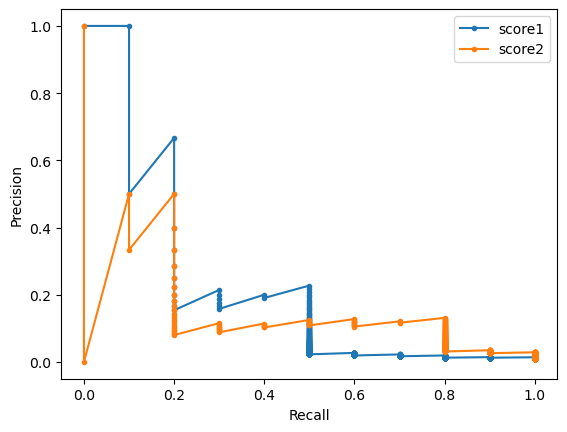

In [88]:

import matplotlib.pyplot as plt
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
 
# # generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# # split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# # fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(trainX, trainy)
# # predict probabilities
# lr_probs = model.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = model.predict(testX)


precision1, recall1, _ = precision_recall_curve(t['y_true'], t['y_score1'])
precision2, recall2, _ = precision_recall_curve(t['y_true'], t['y_score2'])

# lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
# print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
# no_skill = len(testy[testy==1]) / len(testy)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall1, precision1, marker='.', label='score1')
plt.plot(recall2, precision2, marker='.', label='score2')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [89]:
from sklearn.metrics import average_precision_score

In [90]:
average_precision_score(t['y_true'], t['y_score1'])

0.2404742335681647

In [91]:
average_precision_score(t['y_true'], t['y_score2']) # модель начала делать много FP

0.1797651767227378

# human and machine learning compare

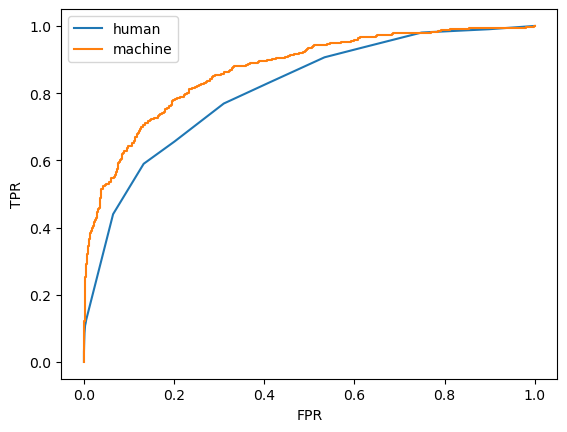

In [92]:
# сначала построи рог кривые

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# в нижнее подчеркивание идут пороги. они не нужны
fpr1, tpr1, _ = roc_curve(test['Exited'], test['score_prod_age'])
fpr2, tpr2, _ = roc_curve(test['Exited'], test['score_catboost'])

# по искусу идет фолс позитв рейт, по игрек тру позитив рейт
plt.plot(fpr1, tpr1, label='human')
plt.plot(fpr2, tpr2, label='machine')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

    видно что ROC кривая находится выше для модели манинного обучения

In [93]:
roc_auc_score(test['Exited'], test['score_prod_age'])

0.8115241589817861

In [94]:
roc_auc_score(test['Exited'], test['score_catboost'])

0.8703063618317854

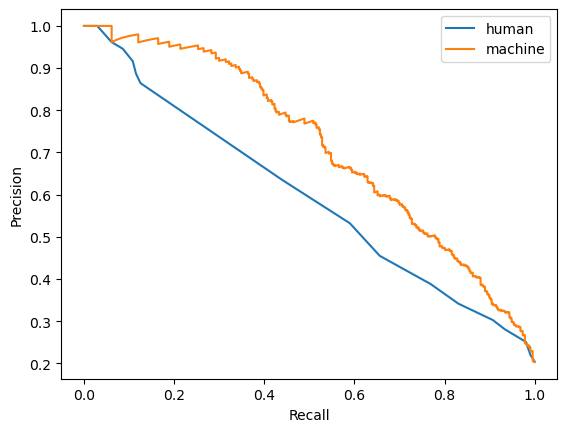

In [95]:
# теперь precsison and recall

precision1, recall1, _ = precision_recall_curve(test['Exited'], test['score_prod_age'])
precision2, recall2, _ = precision_recall_curve(test['Exited'], test['score_catboost'])

plt.plot(recall1, precision1, label='human')
plt.plot(recall2, precision2, label='machine')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [96]:
average_precision_score(test['Exited'], test['score_prod_age'])



0.539602947873155

In [97]:
average_precision_score(test['Exited'], test['score_catboost'])

0.7138074084585948

    с точки зрения precision catboost намного лучше

# дисбаланс классов не проблема
    бороться с дисбалансом классов не нужно, нужно просто уметь с ним работать
    1) undersamplig(выкидывание части наблюдений класса которого много) можно посмотерть например сколько доля отточников. получается 20 процентов. И можно просто убрать большую долю не отточников. что бы было 50 на 50
    
    2) oversampling генерировать спец техниками объектами первого класса
    
    3) дисбаланс классов генерировать весами при обучении

In [98]:
test['Exited'].mean()

0.2035

    балансировка классов не влияет на качество модели
    но это повлияет на то как будут выглядить скоры модели

In [99]:

params = {'verbose':100,
          'eval_metric': 'AUC', # log loss был по умолчанию, а теперь сразу AUC
          'auto_class_weights': 'Balanced', # балансировать веса классов
          'random_seed':42,
          'learning_rate':0.01}

model = CatBoostClassifier(**params)


model.fit(train_data,eval_set=valid_data)

0:	test: 0.8310171	best: 0.8310171 (0)	total: 3.97ms	remaining: 3.96s
100:	test: 0.8726691	best: 0.8727215 (99)	total: 284ms	remaining: 2.53s
200:	test: 0.8780837	best: 0.8781684 (199)	total: 537ms	remaining: 2.13s
300:	test: 0.8805532	best: 0.8806579 (293)	total: 784ms	remaining: 1.82s
400:	test: 0.8818510	best: 0.8818649 (397)	total: 1.03s	remaining: 1.54s
500:	test: 0.8821682	best: 0.8822452 (481)	total: 1.28s	remaining: 1.28s
600:	test: 0.8824284	best: 0.8826070 (561)	total: 1.54s	remaining: 1.02s
700:	test: 0.8823145	best: 0.8826070 (561)	total: 1.82s	remaining: 775ms
800:	test: 0.8819619	best: 0.8826070 (561)	total: 2.16s	remaining: 536ms
900:	test: 0.8814015	best: 0.8826070 (561)	total: 2.42s	remaining: 266ms
999:	test: 0.8803392	best: 0.8826070 (561)	total: 2.68s	remaining: 0us

bestTest = 0.8826069687
bestIteration = 561

Shrink model to first 562 iterations.


<Axes: >

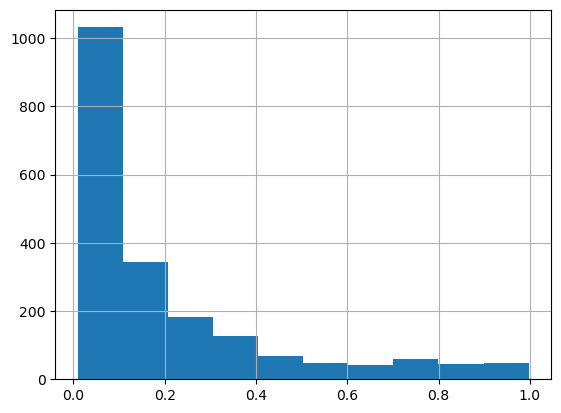

In [100]:
test['score_catboost'].hist()

<Axes: >

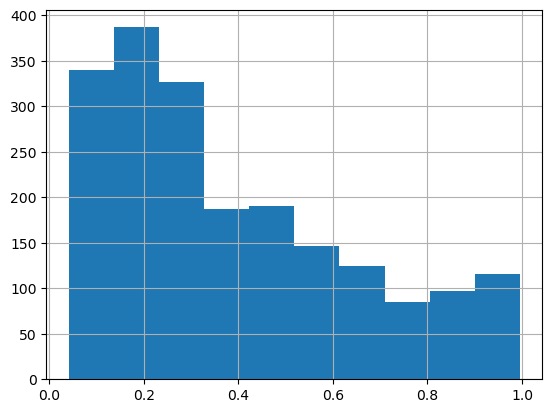

In [101]:
# балансированные классы, не отражают верояттность так же как раньше
pd.Series(model.predict_proba(test[X])[:,1]).hist()

In [102]:
test['score_cat_not_balanced_bins'] = pd.cut(test['score_catboost'], 10)

In [103]:
test.groupby('score_cat_not_balanced_bins')['Exited'].agg(['count', 'mean'])

/tmp/ipykernel_29765/144526038.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test.groupby('score_cat_not_balanced_bins')['Exited'].agg(['count', 'mean'])


,count,mean
score_cat_not_balanced_bins,,
"(0.00838, 0.108]",1032,0.043605
"(0.108, 0.207]",343,0.142857
"(0.207, 0.306]",184,0.260870
"(0.306, 0.405]",128,0.359375
"(0.405, 0.503]",69,0.434783
"(0.503, 0.602]",49,0.530612
"(0.602, 0.701]",42,0.595238
"(0.701, 0.8]",59,0.830508
"(0.8, 0.899]",45,0.911111


In [104]:
test['score_catboost_balanced'] = model.predict_proba(test[X])[:,1]

In [105]:
test['score_cat_balanced_bins'] = pd.cut(test['score_catboost_balanced'], 10)

In [107]:
test.groupby('score_cat_balanced_bins')['Exited'].agg(['count', 'mean'])


/tmp/ipykernel_29765/3064722563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test.groupby('score_cat_balanced_bins')['Exited'].agg(['count', 'mean'])


,count,mean
score_cat_balanced_bins,,
"(0.0404, 0.137]",340,0.011765
"(0.137, 0.232]",387,0.036176
"(0.232, 0.328]",327,0.082569
"(0.328, 0.423]",187,0.139037
"(0.423, 0.518]",190,0.210526
"(0.518, 0.614]",146,0.191781
"(0.614, 0.709]",125,0.464000
"(0.709, 0.805]",85,0.447059
"(0.805, 0.9]",97,0.670103


    Небалансированные скоры: Вероятности отражают реальные шансы событий (например, если модель предсказывает вероятность ухода 0.8, примерно 80% клиентов действительно уйдут).

    Балансированные скоры: Вероятности могут быть завышены для класса меньшинства (например, модель может предсказывать более высокие вероятности ухода, даже когда реальные шансы ниже). Это происходит из-за того, что модель "усиливает" редкий класс.

    После балансировки вероятности могут стать менее точными и требовать калибровки, чтобы снова соответствовать реальным шансам.
    
    
    В случае с кетбустом, балансировка классов не помогает особо. Но если видно что все очень плохо можно поробовать балансировку. но ожидать улучшение качества не стоит

# Мультикласс

   https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

   https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

   https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb
